# cancellation reason
- (A) Air Carrier
- (B) Extreme Weather
- (C) National Aviation System (NAS); and
- (D) Security

# 1. Getting the data

In [23]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import RandomUnderSampler

# performance metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

# for ANOVA test
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

In [5]:
mylist = []

for chunk in  pd.read_csv('flights.csv', sep=',', chunksize=20000):
    mylist.append(chunk)

df_flights = pd.concat(mylist, axis= 0)
del mylist

In [6]:
df_airlines =pd.read_csv('airlines.csv')
df_airports = pd.read_csv('airports.csv')

# Exploratory Data Analysis (EDA)

In [7]:
df_airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


estado y df_fl
ORIGIN_AIRPORT en df_fl = IATA_CODE en df_airports

In [8]:
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_iata_code_state = df_airports[['IATA_CODE', 'STATE']]
df_flights = df_flights.join(df_iata_code_state.set_index('IATA_CODE'), on='ORIGIN_AIRPORT')


In [10]:
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,STATE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AK
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,CA
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,CA
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,CA
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,WA


### Flights filtered by Florida State

In [11]:
df_fl_flights = df_flights[df_flights['STATE'] == 'FL']

In [12]:
df_fl_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,STATE
64,2015,1,1,4,AA,1323,N3CXAA,MCO,MIA,510,...,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,FL
77,2015,1,1,4,EV,5583,N882AS,VPS,ATL,520,...,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,FL
110,2015,1,1,4,EV,4160,N11150,JAX,EWR,540,...,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,FL
144,2015,1,1,4,B6,2228,N231JB,MCO,EWR,550,...,-7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,FL
153,2015,1,1,4,B6,860,N656JB,FLL,BDL,553,...,9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,FL


In [13]:
df_fl_flights.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,415586.0,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,411142.000000,411142.000000,411029.000000,411029.000000,...,415586.000000,410705.000000,409611.000000,415586.000000,415586.000000,80338.000000,80338.000000,80338.000000,80338.000000,80338.000000
mean,2015.0,6.083321,15.704109,3.992353,1556.593242,1340.761412,1349.491254,10.961079,14.678903,1371.893981,...,1519.673841,1492.296427,5.572880,0.003318,0.011059,15.304401,0.104919,18.502527,25.386144,3.181135
std,0.0,3.472485,8.791170,2.002831,1141.071567,467.808764,485.118879,40.113820,6.921939,486.516164,...,500.329446,529.526736,42.027297,0.057508,0.104579,32.506344,2.700770,49.114804,46.503060,18.232280
min,2015.0,1.000000,1.000000,1.000000,1.000000,55.000000,1.000000,-46.000000,1.000000,1.000000,...,1.000000,1.000000,-66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,3.000000,8.000000,2.000000,709.000000,930.000000,933.000000,-5.000000,11.000000,947.000000,...,1123.000000,1104.000000,-14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,6.000000,16.000000,4.000000,1355.000000,1335.000000,1343.000000,-2.000000,13.000000,1356.000000,...,1529.000000,1517.000000,-5.000000,0.000000,0.000000,2.000000,0.000000,3.000000,6.000000,0.000000
75%,2015.0,9.000000,23.000000,6.000000,2077.000000,1745.000000,1757.000000,9.000000,17.000000,1811.000000,...,1940.000000,1934.000000,8.000000,0.000000,0.000000,18.000000,0.000000,17.000000,31.000000,0.000000
max,2015.0,12.000000,31.000000,7.000000,6898.000000,2359.000000,2400.000000,1536.000000,158.000000,2400.000000,...,2400.000000,2400.000000,1556.000000,1.000000,1.000000,784.000000,241.000000,1536.000000,1010.000000,932.000000


In [14]:
df_fl_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415586 entries, 64 to 5819077
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 415586 non-null  int64  
 1   MONTH                415586 non-null  int64  
 2   DAY                  415586 non-null  int64  
 3   DAY_OF_WEEK          415586 non-null  int64  
 4   AIRLINE              415586 non-null  object 
 5   FLIGHT_NUMBER        415586 non-null  int64  
 6   TAIL_NUMBER          414610 non-null  object 
 7   ORIGIN_AIRPORT       415586 non-null  object 
 8   DESTINATION_AIRPORT  415586 non-null  object 
 9   SCHEDULED_DEPARTURE  415586 non-null  int64  
 10  DEPARTURE_TIME       411142 non-null  float64
 11  DEPARTURE_DELAY      411142 non-null  float64
 12  TAXI_OUT             411029 non-null  float64
 13  WHEELS_OFF           411029 non-null  float64
 14  SCHEDULED_TIME       415582 non-null  float64
 15  ELAPSED_TIME   

### We inspect the null values from the Dataframe

In [15]:
df_fl_flights.isnull().sum()

YEAR                        0
MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE                     0
FLIGHT_NUMBER               0
TAIL_NUMBER               976
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
DEPARTURE_TIME           4444
DEPARTURE_DELAY          4444
TAXI_OUT                 4557
WHEELS_OFF               4557
SCHEDULED_TIME              4
ELAPSED_TIME             5975
AIR_TIME                 5975
DISTANCE                    0
WHEELS_ON                4881
TAXI_IN                  4881
SCHEDULED_ARRIVAL           0
ARRIVAL_TIME             4881
ARRIVAL_DELAY            5975
DIVERTED                    0
CANCELLED                   0
CANCELLATION_REASON    410990
AIR_SYSTEM_DELAY       335248
SECURITY_DELAY         335248
AIRLINE_DELAY          335248
LATE_AIRCRAFT_DELAY    335248
WEATHER_DELAY          335248
STATE                       0
dtype: int64

In [16]:
df_fl_flights = df_fl_flights.fillna(0)
# df_fl_flights = df_fl_flights.dropna(axis=0,how='any')
df_fl_flights.isnull().sum()

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
DIVERTED               0
CANCELLED              0
CANCELLATION_REASON    0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
STATE                  0
dtype: int64

### We inspect the dataframe after dropping all null values

In [17]:
df_fl_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415586 entries, 64 to 5819077
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 415586 non-null  int64  
 1   MONTH                415586 non-null  int64  
 2   DAY                  415586 non-null  int64  
 3   DAY_OF_WEEK          415586 non-null  int64  
 4   AIRLINE              415586 non-null  object 
 5   FLIGHT_NUMBER        415586 non-null  int64  
 6   TAIL_NUMBER          415586 non-null  object 
 7   ORIGIN_AIRPORT       415586 non-null  object 
 8   DESTINATION_AIRPORT  415586 non-null  object 
 9   SCHEDULED_DEPARTURE  415586 non-null  int64  
 10  DEPARTURE_TIME       415586 non-null  float64
 11  DEPARTURE_DELAY      415586 non-null  float64
 12  TAXI_OUT             415586 non-null  float64
 13  WHEELS_OFF           415586 non-null  float64
 14  SCHEDULED_TIME       415586 non-null  float64
 15  ELAPSED_TIME   

We saw that I we drop all null values we will be left with no rows, so we fill all null values with 0

In [18]:
df_fl_flights.describe(exclude = ['object'])

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,415586.0,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,...,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000,415586.000000
mean,2015.0,6.083321,15.704109,3.992353,1556.593242,1340.761412,1335.060693,10.843869,14.517946,1356.850835,...,1519.673841,1474.769612,5.492757,0.003318,0.011059,2.958533,0.020282,3.576771,4.907461,0.614953
std,0.0,3.472485,8.791170,2.002831,1141.071567,467.808764,502.085121,39.914692,7.051570,504.493682,...,500.329446,550.412018,41.729357,0.057508,0.104579,15.517404,1.188173,22.796983,22.771463,8.114040
min,2015.0,1.000000,1.000000,1.000000,1.000000,55.000000,0.000000,-46.000000,0.000000,0.000000,...,1.000000,0.000000,-66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,3.000000,8.000000,2.000000,709.000000,930.000000,926.000000,-5.000000,11.000000,939.000000,...,1123.000000,1053.000000,-13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,6.000000,16.000000,4.000000,1355.000000,1335.000000,1338.000000,-2.000000,13.000000,1350.000000,...,1529.000000,1511.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2015.0,9.000000,23.000000,6.000000,2077.000000,1745.000000,1755.000000,9.000000,17.000000,1809.000000,...,1940.000000,1930.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2015.0,12.000000,31.000000,7.000000,6898.000000,2359.000000,2400.000000,1536.000000,158.000000,2400.000000,...,2400.000000,2400.000000,1556.000000,1.000000,1.000000,784.000000,241.000000,1536.000000,1010.000000,932.000000


### Our dependet variable is Delay, overall delay, whether if it's an arriving delay or a departure delay, so we will mix both variables

In [19]:
SUM_DELAYS= ['DEPARTURE_DELAY','ARRIVAL_DELAY','AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY','LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df_fl_flights['DELAY'] = df_fl_flights[SUM_DELAYS].sum(axis=1)

In [20]:
df_fl_flights[['AIRLINE', 'DELAY']].groupby(['AIRLINE']).describe()

DELAY                                                       
           count       mean         std   min   25%   50%   75%     max
AIRLINE                                                                
AA       83320.0  29.647480  125.377889 -67.0 -17.0  -6.0  21.0  4648.0
AS        1320.0  16.384091   86.411880 -66.0 -22.0  -6.0  17.0  1029.0
B6       56189.0  42.029739  124.089239 -69.0 -16.0  -3.0  37.0  1813.0
DL       73662.0  18.927385  125.554176 -67.0 -19.0 -11.0   4.0  3837.0
EV       10853.0  32.238828  131.181316 -79.0 -18.0  -7.0  14.0  2435.0
F9       10974.0  59.011573  171.079428 -77.0 -17.0   0.0  62.0  2385.0
MQ        9400.0  24.819681  102.433790 -58.0 -17.0  -7.0  11.0  1414.0
NK       21209.0  42.915838  122.485496 -58.0 -14.0  -1.0  42.0  2502.0
OO         590.0  54.442373  131.751860 -65.0 -12.0   2.0  58.0   959.0
UA       30400.0  27.626612  119.487785 -66.0 -20.0  -7.0  15.0  3143.0
US       18219.0  14.281958   85.321331 -69.0 -16.0  -7.0   6.0  2259.0
VX        1574.0  18.624524  101.766299 -63.0 -20.0  -6.0  13.0  1561.0
WN       97876.0  23.075647   97.857257 -71.0 -17.0  -7.0  13.0  1660.0

<AxesSubplot:title={'center':'DELAY'}, xlabel='AIRLINE'>

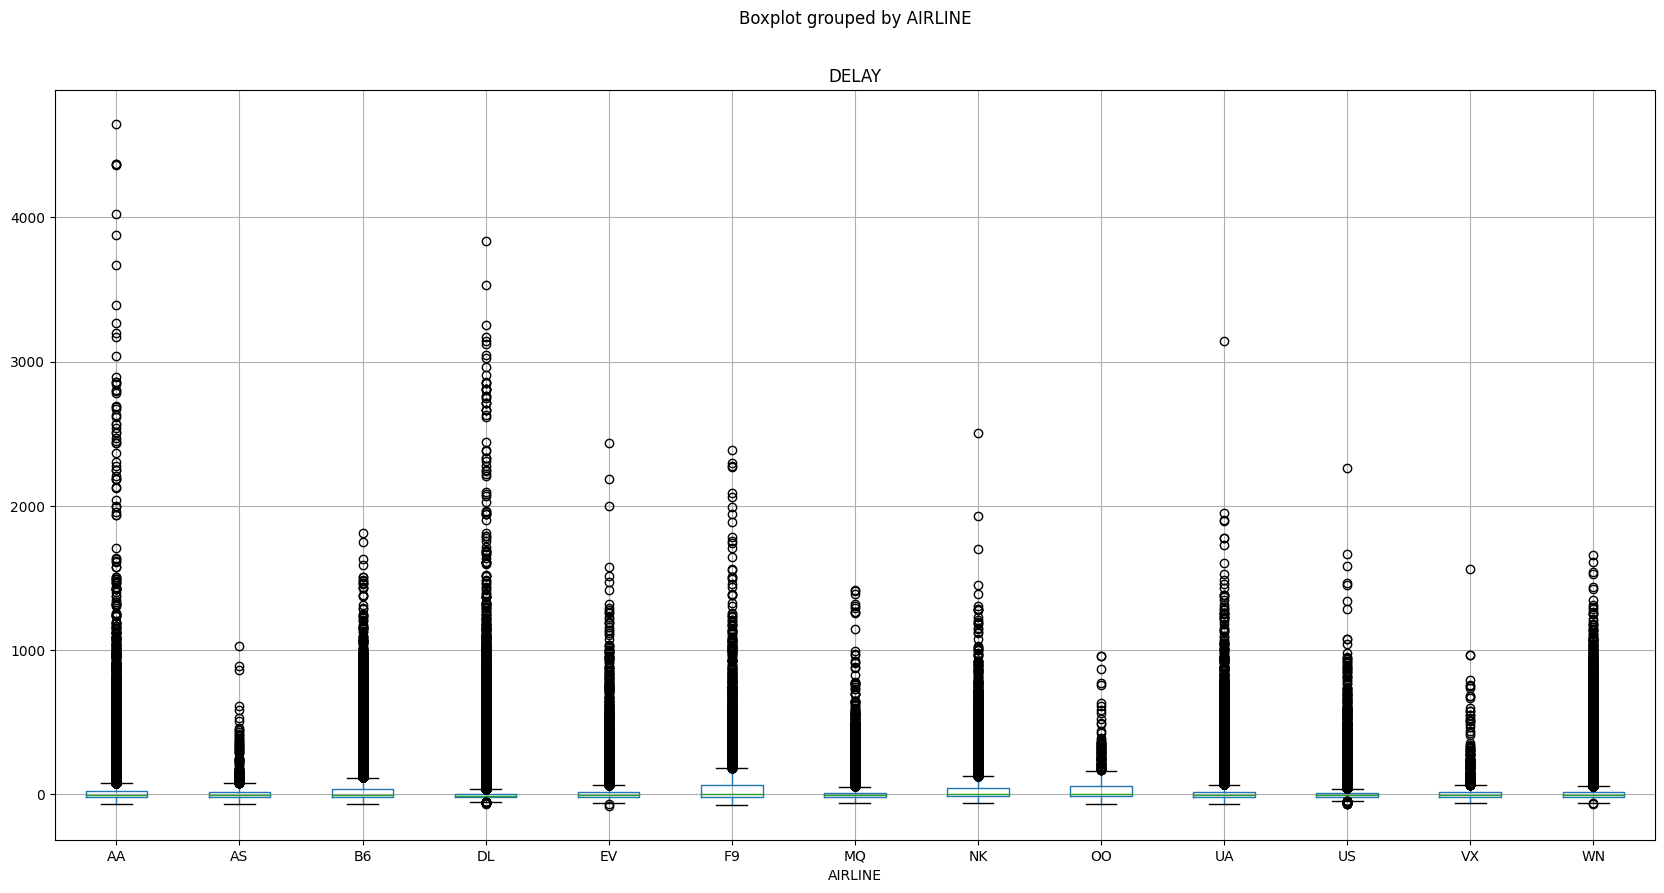

In [21]:
df_fl_flights.boxplot(column='DELAY', by='AIRLINE', figsize=(20, 10))

# We perfom ANOVA test

In [22]:
mod = ols('DELAY ~ AIRLINE', data=df_fl_flights).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq        df           F  PR(>F)
AIRLINE   3.937565e+07      12.0  235.063518     0.0
Residual  5.801077e+09  415573.0         NaN     NaN


In [24]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_fl_flights['DELAY'].mean()
SSTR = df_fl_flights.groupby('AIRLINE').count() * (df_fl_flights.groupby('AIRLINE').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['DELAY'].sum()

# calculate SSE and update anova table
SSE = (df_fl_flights.groupby('AIRLINE').count() - 1) * df_fl_flights.groupby('AIRLINE').std()**2
anova_table['SS']['Within Groups'] = SSE['DELAY'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['DELAY'].sum() + SSE['DELAY'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_fl_flights['AIRLINE'].nunique() - 1
anova_table['df']['Within Groups'] = df_fl_flights.shape[0] - df_fl_flights['AIRLINE'].nunique()
anova_table['df']['Total'] = df_fl_flights.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,39375651.11439,12,3281304.259532,235.063518,0.0,1.944753
Within Groups,5801076520.336502,415573,13959.223819,,,
Total,5840452171.450891,415585,14053.568275,,,


In [27]:
# p-value approach
print("The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)

The p-value approach to hypothesis testing in the decision rule
F-score is: 235.0635179981365  and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.


In [15]:
df_fl = df_fl_flights[['MONTH', 'DAY', 'AIRLINE', 'SCHEDULED_DEPARTURE', 'STATE', 'WEATHER_DELAY', 'CANCELLATION_REASON']]

In [10]:
dependentVar1= (df_fl['WEATHER_DELAY'])


dependentVar= np.where(( (df_fl['CANCELLATION_REASON']=='B') ), 1,0)
dependentVar= np.where(( (df_fl['WEATHER_DELAY'].notna()) ), 1,0)
#assign the dependent variable to the key 'WEATHER_CONDITION' in the dataframe df_fl
df_fl['WEATHER_CONDITION'] = dependentVar

C:\Users\coraj\AppData\Local\Temp\ipykernel_15652\4080105368.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['WEATHER_CONDITION'] = dependentVar


In [12]:
df_fl.drop(['SCHEDULED_DEPARTURE'], axis=1, inplace=True)
df_fl.drop(['WEATHER_DELAY'], axis=1, inplace=True)
df_fl.drop(['CANCELLATION_REASON'], axis=1, inplace=True)

C:\Users\coraj\AppData\Local\Temp\ipykernel_15652\2728054226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl.drop(['SCHEDULED_DEPARTURE'], axis=1, inplace=True)
C:\Users\coraj\AppData\Local\Temp\ipykernel_15652\2728054226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl.drop(['WEATHER_DELAY'], axis=1, inplace=True)
C:\Users\coraj\AppData\Local\Temp\ipykernel_15652\2728054226.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [13]:
df_fl

,MONTH,DAY,AIRLINE,STATE,WEATHER_CONDITION
0,1,1,AS,AK,0
1,1,1,AA,CA,0
2,1,1,US,CA,0
3,1,1,AA,CA,0
4,1,1,AS,WA,0
...,...,...,...,...,...
5819074,12,31,B6,CA,0
5819075,12,31,B6,NY,0
5819076,12,31,B6,NY,0
5819077,12,31,B6,FL,0


In [17]:
df_fl.dropna(subset=['STATE'], inplace=True)

C:\Users\coraj\AppData\Local\Temp\ipykernel_15652\3001793961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl.dropna(subset=['STATE'], inplace=True)


In [18]:
states=df_fl['STATE'].unique()

In [19]:
states = states.tolist()

In [20]:
fl_number = states.index('FL')

In [21]:
states_index = np.arange(0, len(states))

In [22]:
df_fl['STATE'].replace(states, states_index, inplace=True)

C:\Users\coraj\AppData\Local\Temp\ipykernel_15652\1278447534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['STATE'].replace(states, states_index, inplace=True)


In [23]:
df_fl

,MONTH,DAY,AIRLINE,STATE,WEATHER_CONDITION
0,1,1,AS,0,0
1,1,1,AA,1,0
2,1,1,US,1,0
3,1,1,AA,1,0
4,1,1,AS,2,0
...,...,...,...,...,...
5819074,12,31,B6,1,0
5819075,12,31,B6,10,0
5819076,12,31,B6,10,0
5819077,12,31,B6,13,0


In [24]:
airline_code = df_fl['AIRLINE'].unique()

airline_index = np.arange(0, len(airline_code))

df_fl['AIRLINE'].replace(airline_code, airline_index, inplace=True)


C:\Users\coraj\AppData\Local\Temp\ipykernel_15652\602713389.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['AIRLINE'].replace(airline_code, airline_index, inplace=True)


In [26]:
df_fl

,MONTH,DAY,AIRLINE,STATE,WEATHER_CONDITION
0,1,1,0,0,0
1,1,1,1,1,0
2,1,1,2,1,0
3,1,1,1,1,0
4,1,1,0,2,0
...,...,...,...,...,...
5819074,12,31,7,1,0
5819075,12,31,7,10,0
5819076,12,31,7,10,0
5819077,12,31,7,13,0


In [27]:
df_fl = df_fl[(df_fl['MONTH'] == 1) | (df_fl['MONTH'] == 12)]

In [ ]:
corr = df_fl.corr()

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [28]:
dependentVar = df_fl['WEATHER_CONDITION']
df_fl.drop(['WEATHER_CONDITION'], axis=1, inplace=True)

C:\Users\coraj\AppData\Local\Temp\ipykernel_15652\1183529647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl.drop(['WEATHER_CONDITION'], axis=1, inplace=True)


In [ ]:
corr = df_fl.corr()

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split( df_fl, dependentVar, test_size = 0.3, random_state = 746)

In [30]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# apply near miss 

rd = RandomUnderSampler() 
  
X_train_rd, y_train_rd = rd.fit_resample(X_train, y_train.ravel()) 
X_test_rd, y_test_rd = rd.fit_resample(X_test, y_test.ravel()) 

  
print('After Undersampling, the shape of X_train: {}'.format(X_train_rd.shape)) 
print('After Undersampling, the shape of y_train: {} \n'.format(y_train_rd.shape)) 

print('After Undersampling, the shape of X_test: {}'.format(X_test_rd.shape)) 
print('After Undersampling, the shape of y_test: {} \n'.format(y_test_rd.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_rd == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_rd == 0)))

Before Undersampling, counts of label '1': 134812
Before Undersampling, counts of label '0': 529626 

After Undersampling, the shape of X_train: (269624, 4)
After Undersampling, the shape of y_train: (269624,) 

After Undersampling, the shape of X_test: (115822, 4)
After Undersampling, the shape of y_test: (115822,) 

After Undersampling, counts of label '1': 134812
After Undersampling, counts of label '0': 134812


In [31]:
#create list of model and accuracy dicts
perform_list = []

# list to keep track of models
models = []

# list to keep track of proba scores
proba_score = []

In [32]:
dt = DecisionTreeClassifier()

# calculate accuracy of train
dt_acc = cross_val_score(dt, X_train_rd, y_train_rd, cv=10).mean()
dt_std = cross_val_score(dt, X_train_rd, y_train_rd, cv=10).std()
print('Accuracy of Decision Tree (TRAIN): {} +/- {}'.format(round(dt_acc, 2), round(dt_std, 2)))

# fit model
dt.fit(X_train_rd, y_train_rd)


Accuracy of Decision Tree (TRAIN): 0.66 +/- 0.0


DecisionTreeClassifier()

In [33]:

# get predictions and probabilities
dt_pred = dt.predict(X_test_rd)
dt_proba = dt.predict_proba(X_test_rd)

# calculate accuracy of test
dt_acc_test = round(accuracy_score(y_test_rd, dt_pred), 2)
print(f'Accuracy of Decision Tree (TEST): {dt_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_test_rd, dt_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Decision Tree'),
    ('Train Accuracy', round(dt_acc, 2)),
    ('Test Accuracy', dt_acc),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Decision Tree')
# add proba socre to list
proba_score.append(dt_proba)

Accuracy of Decision Tree (TEST): 0.66
Precision : 0.6637214558578505
Recall    : 0.6630778263196975
F-score   : 0.662746369460046


In [34]:
rf = RandomForestClassifier(n_estimators=100)

In [35]:
# fit model
rf.fit(X_train_rd, y_train_rd)


RandomForestClassifier()

In [36]:
# calculate accuracy of train
rf_acc = cross_val_score(rf, X_train_rd, y_train_rd, cv=10).mean()
rf_std = cross_val_score(rf, X_train_rd, y_train_rd, cv=10).std()
print('Accuracy of Random Forest (TRAIN): {} +/- {}'.format(round(rf_acc, 2), round(rf_std, 2)))

# get predictions and probabilities
rf_pred = rf.predict(X_test_rd)
rf_proba= rf.predict_proba(X_test_rd)

# calculate accuracy of test
rf_acc_test = round(accuracy_score(y_test_rd, rf_pred), 2)
print(f'Accuracy of Random Forest (TEST): {rf_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_test_rd, rf_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Random Forest'),
    ('Train Accuracy', round(rf_acc, 2)),
    ('Test Accuracy', rf_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Random Forest')

# add proba socre to list
proba_score.append(rf_proba)

Accuracy of Random Forest (TRAIN): 0.66 +/- 0.0
Accuracy of Random Forest (TEST): 0.66
Precision : 0.662558468704715
Recall    : 0.6624648167014902
F-score   : 0.6624161951196138


### Logistic regression

In [37]:
lr = LogisticRegression(random_state=1)

# calculate accuracy of train
lr_acc = cross_val_score(lr, X_train_rd, y_train_rd, cv=10).mean()
lr_std = cross_val_score(lr, X_train_rd, y_train_rd, cv=10).std()
print('Accuracy of Logistic Regression (TRAIN): {} +/- {}'.format(round(lr_acc, 2), round(lr_std, 2)))

# fit model
lr.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
lr_pred = lr.predict(X_test_rd)
lr_proba = lr.predict_proba(X_test_rd)

# calculate accuracy of test
lr_acc_test = round(accuracy_score(y_test_rd, lr_pred), 2)
print(f'Accuracy of Logistic Regression (TEST): {lr_acc_test}')

print()

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_test_rd, lr_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Logistic Regression'),
    ('Train Accuracy', round(lr_acc, 2)),
    ('Test Accuracy', lr_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Logistic Regression')

# add proba score to list
proba_score.append(lr_proba)

Accuracy of Logistic Regression (TRAIN): 0.53 +/- 0.0
Accuracy of Logistic Regression (TEST): 0.53

Precision : 0.5302059599641626
Recall    : 0.5301497124898551
F-score   : 0.5299308798423393


### Navie bayes

In [38]:
nb = GaussianNB()

# calculate accuracy of train
nb_acc = cross_val_score(nb, X_train_rd, y_train_rd, cv=10).mean()
nb_std = cross_val_score(nb, X_train_rd, y_train_rd, cv=10).std()
print('Accuracy of Naive Bayes Classifier (TRAIN): {} +/- {}'.format(round(nb_acc, 2), round(nb_std, 2)))

# cit model
nb.fit(X_train_rd, y_train_rd)

# get predictions and probabilities
nb_pred = nb.predict(X_test_rd)
nb_proba = nb.predict_proba(X_test_rd)

# calculate accuracy of test
nb_acc_test = round(accuracy_score(y_test_rd, nb_pred), 2)
print(f'Accuracy of Naive Bayes Classifier (TEST): {nb_acc_test}')

# get precision, recall, f1-score
precision, recall, fscore, support = score(y_test_rd, nb_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

# add model and accuracy dict to list
perform_list.append(dict([
    ('Model', 'Naive Bayes'),
    ('Train Accuracy', round(nb_acc, 2)),
    ('Test Accuracy', nb_acc_test),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(fscore, 2))
     ]))

# add model to list
models.append('Naive Bayes')

# add proba score to list
proba_score.append(nb_proba)

Accuracy of Naive Bayes Classifier (TRAIN): 0.54 +/- 0.0
Accuracy of Naive Bayes Classifier (TEST): 0.54
Precision : 0.5358605391934395
Recall    : 0.5356236293622973
F-score   : 0.5348553940503726


In [39]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1
0,Decision Tree,0.66,0.660197,0.66,0.66,0.66
1,Random Forest,0.66,0.660000,0.66,0.66,0.66
2,Logistic Regression,0.53,0.530000,0.53,0.53,0.53
3,Naive Bayes,0.54,0.540000,0.54,0.54,0.53
